In [12]:


import torch
import pandas as pd, psycopg2, os
from sklearn.preprocessing import StandardScaler
import numpy as np  
import torch
from torch.utils.data import Dataset, DataLoader
import joblib
import torch.nn as nn
import datetime as dt
from dotenv import load_dotenv
import matplotlib.pyplot as plt
# --- TensorBoard ---
from torch.utils.tensorboard import SummaryWriter
import time
from BoatRaceDataset import BoatRaceDataset
import itertools

# --- reproducibility helpers ---
import random  # reproducibility helpers

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ----------------------------------------------------------------------
# Feature‑engineering registry (declarative “add / drop” infrastructure)
# ----------------------------------------------------------------------
from dataclasses import dataclass, field
from typing import Callable, Sequence, Dict
import pandas as pd  # already imported above, but kept for clarity

@dataclass
class FeatureDef:
    """Declarative feature definition."""
    name: str
    fn: Callable[[pd.DataFrame], pd.Series]
    deps: Sequence[str] = field(default_factory=tuple)  # for documentation
    dtype: str = None                            # optional cast

FEATURE_REGISTRY: Dict[str, FeatureDef] = {}

def register_feature(fd: FeatureDef):
    """Add a feature definition to the global registry."""
    FEATURE_REGISTRY[fd.name] = fd

def apply_features(
    df: pd.DataFrame,
    include: Sequence[str] = None,
    exclude: Sequence[str] = None,
    inplace: bool = False,
) -> pd.DataFrame:
    """
    Materialise features declared in the registry.

    Parameters
    ----------
    df : DataFrame
        Source dataframe.
    include / exclude : list[str] | None
        White‑/black‑lists of feature names.  `include=None` means “all”.
    inplace : bool
        If False (default), work on a copy to avoid side‑effects.
    """
    if not inplace:
        df = df.copy()

    names = include if include is not None else list(FEATURE_REGISTRY)
    if exclude:
        names = [n for n in names if n not in exclude]

    for n in names:
        fd = FEATURE_REGISTRY[n]
        df[n] = fd.fn(df)
        if fd.dtype:
            df[n] = df[n].astype(fd.dtype)
    return df

# --------------------------- default features --------------------------
def _wind_sin(df: pd.DataFrame) -> pd.Series:
    """Sine of wind direction (deg → rad)."""
    return np.sin(np.deg2rad(df["wind_dir_deg"]))

def _wind_cos(df: pd.DataFrame) -> pd.Series:
    """Cosine of wind direction (deg → rad)."""
    return np.cos(np.deg2rad(df["wind_dir_deg"]))

register_feature(FeatureDef("wind_sin", _wind_sin, deps=["wind_dir_deg"]))
register_feature(FeatureDef("wind_cos", _wind_cos, deps=["wind_dir_deg"]))

In [13]:


import nbformat
from nbconvert import PythonExporter

with open("main2.ipynb", "r", encoding="utf-8") as f:
    nb = nbformat.read(f, as_version=4)

exporter = PythonExporter()
source, _ = exporter.from_notebook_node(nb)

with open("main2.py", "w", encoding="utf-8") as f:
    f.write(source)

In [14]:


load_dotenv(override=True)

DB_CONF = {
    "host":     os.getenv("PGHOST", "localhost"),
    "port":     int(os.getenv("PGPORT", 5432)),
    "dbname":   os.getenv("PGDATABASE", "boatrace"),
    "user":     os.getenv("PGUSER", "br_user"),
    "password": os.getenv("PGPASSWORD", "secret"),
}

# ------------------------------------------------------------------
# DB 接続
# ------------------------------------------------------------------
conn = psycopg2.connect(**DB_CONF)
df = pd.read_sql("""
    SELECT * FROM feat.train_features2
    WHERE race_date <= '2024-12-31'
""", conn)


print(f"Loaded {len(df)} rows from the database.")

# ------------------------------------------------------------------
# Low‑cost performance boost:
# 30‑day rolling stats per racer (starts, win‑rate, etc.)
# ------------------------------------------------------------------
try:
    hist30 = pd.read_sql("SELECT * FROM feat.racer_hist_30d", conn)
    # add lane‑specific suffixes and left‑join for every lane
    for lane in range(1, 7):
        df = df.merge(
            hist30.add_suffix(f"_l{lane}"),            # e.g. starts_30d_l1
            how="left",
            left_on=f"lane{lane}_racer_id",
            right_on=f"racer_id_l{lane}"
        )
    print(f"[info] merged 30‑day stats ‑ new shape: {df.shape}")
except Exception as e:
    # keep pipeline running even if the view is missing
    print("[warn] 30‑day stats merge skipped:", e)

Loaded 2076 rows from the database.
[info] merged 30‑day stats ‑ new shape: (2076, 93)


/var/folders/9n/_65_h0_d791gcmmvjcjjkn9r0000gn/T/ipykernel_72667/2476864942.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("""
/var/folders/9n/_65_h0_d791gcmmvjcjjkn9r0000gn/T/ipykernel_72667/2476864942.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  hist30 = pd.read_sql("SELECT * FROM feat.racer_hist_30d", conn)


In [15]:


# --- 追加特徴量（Feature Registry 経由） ---
df = apply_features(df)

exclude = []

#  

df.drop(columns=exclude, inplace=True, errors="ignore")


# numeric columns for StandardScaler
BASE_NUM_COLS = ["air_temp", "wind_speed", "wave_height",
                 "water_temp", "wind_sin", "wind_cos"]
# automatically pick up newly merged rolling features (suffix *_30d)
HIST_NUM_COLS = [c for c in df.columns
                 if c.endswith("_30d") and df[c].dtype != "object"]
NUM_COLS = BASE_NUM_COLS + HIST_NUM_COLS
print(f"[info] StandardScaler will use {len(NUM_COLS)} numeric cols "
      f"({len(BASE_NUM_COLS)} base + {len(HIST_NUM_COLS)} hist)")
scaler = StandardScaler().fit(df[NUM_COLS])
df[NUM_COLS] = scaler.transform(df[NUM_COLS])

bool_cols = [c for c in df.columns if c.endswith("_fs_flag")]
df[bool_cols] = df[bool_cols].fillna(False).astype(bool)

rank_cols = [f"lane{l}_rank" for l in range(1, 7)]
df[rank_cols] = df[rank_cols].fillna(7).astype("int32")
df.to_csv("artifacts/train_features.csv", index=False)
display(df.head())
print("データフレーム全体の欠損値の総数:", df.isnull().sum().sum())

# 各列の欠損値の割合を表示（0〜1の値）
missing_ratio = df.isnull().mean()

# パーセント表示にする場合（見やすさのため）
missing_ratio_percent = missing_ratio * 100

print("各列の欠損値の割合（%）:")
print(missing_ratio_percent.sort_values(ascending=False))

os.makedirs("artifacts", exist_ok=True)
scaler_filename = "artifacts/wind_scaler.pkl"
joblib.dump(scaler, scaler_filename)

[info] StandardScaler will use 6 numeric cols (6 base + 0 hist)


/var/folders/9n/_65_h0_d791gcmmvjcjjkn9r0000gn/T/ipykernel_72667/1708089161.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[bool_cols] = df[bool_cols].fillna(False).astype(bool)


,race_key,race_date,venue,air_temp,wind_speed,wave_height,water_temp,weather_txt,wind_dir_deg,lane1_racer_id,...,winrate_30d_l5,exh_mean_30d_l5,st_mean_30d_l5,racer_id_l6,starts_30d_l6,winrate_30d_l6,exh_mean_30d_l6,st_mean_30d_l6,wind_sin,wind_cos
0,若松_20240101_1,2024-01-01,若松,-1.464009,-1.163734,-1.205108,-1.263955,晴,67.5,5104,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.779280,0.288354
1,若松_20240101_10,2024-01-01,若松,-1.338795,-1.163734,-1.205108,-1.263955,晴,67.5,4413,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.779280,0.288354
2,若松_20240101_11,2024-01-01,若松,-1.464009,-1.811120,-1.205108,-1.263955,晴,NaN,4155,...,0.125,6.94625,0.15125,4958.0,8.0,0.5,6.945000,0.136250,NaN,NaN
3,若松_20240101_12,2024-01-01,若松,-1.464009,-0.516349,-0.543049,-1.263955,晴,67.5,4349,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.779280,0.288354
4,若松_20240101_2,2024-01-01,若松,-1.213581,-1.163734,-1.205108,-1.263955,晴,22.5,5155,...,NaN,NaN,NaN,4632.0,7.0,0.0,6.954286,0.235714,0.028337,1.278569


データフレーム全体の欠損値の総数: 55986
各列の欠損値の割合（%）:
st_mean_30d_l3     90.751445
racer_id_l3        90.751445
starts_30d_l3      90.751445
winrate_30d_l3     90.751445
exh_mean_30d_l3    90.751445
                     ...    
lane3_fs_flag       0.000000
lane4_fs_flag       0.000000
lane3_weight        0.000000
lane3_racer_id      0.000000
race_key            0.000000
Length: 95, dtype: float64


['artifacts/wind_scaler.pkl']

In [16]:


def encode(col):
    uniq = sorted(df[col].dropna().unique())
    mapping = {v:i for i,v in enumerate(uniq)}
    df[col + "_id"] = df[col].map(mapping).fillna(-1).astype("int16")
    return mapping
venue2id = encode("venue")
# race_type2id = encode("race_type")

In [17]:


# ============================================================
# 0) ── データの“ラベル & 特徴量”を 1 行だけ覗く可視化 Snippet
#      ★★ ここは notebook なら「1 セルだけ」実行すれば OK ★★
# ------------------------------------------------------------
def peek_one(df: pd.DataFrame, seed: int = 0) -> None:
    """
    ランダムに 1 レース（1 行）だけ抜き取り、順位と主要特徴量を一覧表示
    """
    row = df.sample(1, random_state=seed).squeeze()

    def lane_list(prefix: str):
        return [row[f"lane{i}_{prefix}"] for i in range(1, 7)]

    print("── sample race ──")
    print("rank    :", lane_list("rank"))
    print("exh_time:", lane_list("exh_time"))
    print("st      :", lane_list("st"))
    print("fs_flag :", lane_list("fs_flag"))
    print("weight  :", lane_list("weight"))

# ---------------------------------------------
# ここで一度だけ呼んで目視確認しておくとズレにすぐ気付けます
# peek_one(df)
# ============================================================


LANE_DIM = 8
class SimpleCPLNet(nn.Module):
    """
    ctx(6) + boat(6) → lane ごとにスコア 1 個
    """
    def __init__(self, ctx_in=6, boat_in=6, hidden=64, lane_dim=LANE_DIM):
        super().__init__()
        self.lane_emb = nn.Embedding(6, lane_dim)
        self.ctx_fc   = nn.Linear(ctx_in, hidden)
        self.boat_fc  = nn.Linear(boat_in + lane_dim, hidden)
        self.head = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )

        # 重み初期化を対称性ブレイク用に Xavier で揃える
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, ctx, boats, lane_ids):  # boats:(B,6,4) lane_ids:(B,6)
        B, L, _ = boats.size()
        ctx_emb  = self.ctx_fc(ctx)           # (B,h)
        # DataLoader から来る lane_ids が (B,) なら (B,6) へブロードキャスト
        # -------- lane_ids の形状を必ず (B,6) にそろえる --------
        if lane_ids.dim() == 1:               # (B,) → (B,6)
            lane_ids = lane_ids.unsqueeze(1).expand(-1, L)
        elif lane_ids.dim() == 2 and lane_ids.size(1) == 1:  # (B,1) → (B,6)
            lane_ids = lane_ids.expand(-1, L)
        # 以外 (既に (B,6)) はそのままで OK
        lane_ids = lane_ids.contiguous()      # Embedding 要求に備え contiguous 化

        lane_emb = self.lane_emb(lane_ids)    # (B,6,lane_dim)
        boat_inp = torch.cat([boats, lane_emb], dim=-1)
        boat_emb = self.boat_fc(boat_inp)     # (B,6,h)

        # broadcast ctx → 各 lane
        score = self.head(torch.tanh(ctx_emb.unsqueeze(1) + boat_emb))  # (B,6,1)
        return score.squeeze(-1)           # (B,6)

# ====================== PairwiseModel追加 ======================
class PairwiseModel(nn.Module):
    """
    各艇の特徴量からペアワイズ比較スコアを学習するモデル
    """
    def __init__(self, boat_dim, hidden_dim=64):
        super().__init__()
        self.boat_fc = nn.Linear(boat_dim, hidden_dim)
        self.pair_fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, boats):  # boats: (B, 6, F)
        emb = self.boat_fc(boats)  # (B, 6, H)

        pairwise_scores = []
        for i in range(6):
            for j in range(6):
                if i == j:
                    continue
                diff = emb[:, i] - emb[:, j]  # (B, H)
                score_ij = self.pair_fc(diff)  # (B, 1)
                pairwise_scores.append(score_ij)

        pairwise_scores = torch.cat(pairwise_scores, dim=1)  # (B, 30)
        return pairwise_scores


# ====================== PairwiseModel 用 utility ======================
def pairwise_scores_to_ranks(pairwise_scores: torch.Tensor) -> torch.Tensor:
    """
    ペアワイズスコア (B, 30) を各艇ごとの総勝利数に変換し、
    それをもとに1〜6位の順位を決定する。
    """
    B = pairwise_scores.size(0)
    wins = torch.zeros(B, 6, device=pairwise_scores.device)
    idx = 0
    for i in range(6):
        for j in range(6):
            if i == j:
                continue
            wins[:, i] += (pairwise_scores[:, idx] > 0).float()
            idx += 1
    # 勝利数が多い艇が上位（順位1）となる
    return wins.argsort(dim=1, descending=True).argsort(dim=1) + 1  # (B, 6)


def pairwise_margin_loss(pairwise_scores: torch.Tensor, ranks: torch.Tensor, margin=1.0) -> torch.Tensor:
    """
    正解順位に基づいて i が j に勝つべきペアを抽出し、
    それに対して MarginRankingLoss を適用。
    """
    B = ranks.size(0)
    target = []
    output = []

    idx = 0
    for i in range(6):
        for j in range(6):
            if i == j:
                continue
            # iがjより上位（rankが小さい）なら1、それ以外は-1
            target_ij = torch.sign(ranks[:, j] - ranks[:, i])  # (B,)
            target.append(target_ij)
            output.append(pairwise_scores[:, idx])
            idx += 1

    target = torch.stack(target, dim=1)  # (B,30)
    output = torch.stack(output, dim=1)  # (B,30)

    loss_fn = nn.MarginRankingLoss(margin=margin, reduction='mean')
    # flattenして loss 計算
    return loss_fn(output.view(-1), torch.zeros_like(output).view(-1), target.view(-1))

In [18]:


def pl_nll(scores: torch.Tensor, ranks: torch.Tensor) -> torch.Tensor:
    """
    scores : (B, 6) ― lane0 – lane5 のスコア
    ranks  : (B, 6) ― **1 が 1 着, … 6 が 6 着**（列番号ではない）
   """
    scores = scores.clamp(-20.0, 20.0)

    # 着順 (1 → 6) に並んだ lane index を取得
    order = torch.argsort(ranks, dim=1)      # shape (B,6)

    nll = torch.zeros(scores.size(0), device=scores.device)
    s   = scores.clone()
    for pos in range(6):
        log_denom = torch.logsumexp(s, dim=1)            # log Σₗ exp
        idx       = order[:, pos]                        # (B,)
        chosen    = s.gather(1, idx.unsqueeze(1)).squeeze(1)
        nll      += log_denom - chosen
        s         = s.scatter(1, idx.unsqueeze(1), float('-inf'))

    return nll.mean()

# ── pl_nll が正しいか 3 秒で判定 ──
scores = torch.tensor([[6, 5, 4, 3, 2, 1]], dtype=torch.float32)  # lane0 が最強
ranks  = torch.tensor([[1, 2, 3, 4, 5, 6]], dtype=torch.int64)    # lane0 が 1 着
print("pl_nll should be ~0 :", pl_nll(scores, ranks).item())

pl_nll should be ~0 : 2.0691652297973633


In [19]:


df["race_date"] = pd.to_datetime(df["race_date"]).dt.date
latest_date = df["race_date"].max()
cutoff = latest_date - dt.timedelta(days=90)

mode = "zscore"  # "raw", "log", "zscore" も試せる
ds_train = BoatRaceDataset(df[df["race_date"] <  cutoff], mode=mode)
ds_val   = BoatRaceDataset(df[df["race_date"] >= cutoff], mode=mode)
print(f"train: {len(ds_train)}  val: {len(ds_val)}")
# print("train:", ds_train[0])  # 1 レースの特徴量を確認

loader_train = DataLoader(ds_train, batch_size=256, shuffle=True)
loader_val   = DataLoader(ds_val,   batch_size=512)

# ------------------- ⑤ 学習ループ（LR↓ + Clip） --------------
device = "cuda" if torch.cuda.is_available() else "cpu"
boat_dim = ds_train.boat_dim
model = SimpleCPLNet(boat_in=boat_dim).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

EPOCHS = 20
# --- TensorBoard setup ---
log_dir = os.path.join("artifacts", "tb", time.strftime("%Y%m%d-%H%M%S"))
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)
for epoch in range(EPOCHS):
    if epoch == 0:                  # 1 エポック目だけ試す例
        ctx, boats, lane_ids, ranks = next(iter(loader_train))
        ctx, boats = ctx.to(device), boats.to(device)
        lane_ids = lane_ids.to(device)

        scores = model(ctx, boats, lane_ids)
        scores.sum().backward()     # ダミー backward
        grad_norm = sum(p.grad.abs().mean().item() for p in model.parameters())
        print(f"[debug] average |grad| = {grad_norm:.3e}")
    # ---- train ----
    model.train(); tr_sum = 0
    for ctx, boats, lane_ids, ranks in loader_train:
        ctx, boats = ctx.to(device), boats.to(device)
        lane_ids, ranks = lane_ids.to(device), ranks.to(device)

        scores = model(ctx, boats, lane_ids)
        pl_loss = pl_nll(scores, ranks)
        pred_rank = scores.argsort(dim=1, descending=True).argsort(dim=1) + 1  # 1〜6 着になるよう変換
        l1_loss = nn.L1Loss()(pred_rank.float(), ranks.float())
        loss = pl_loss + 0.3 * l1_loss  # alpha=0.3 は調整可能
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)  # ★勾配爆発対策★
        opt.step()

        tr_sum += loss.item() * len(ctx)

    tr_nll = tr_sum / len(loader_train.dataset)

    # ---- validation ----
    model.eval(); val_sum = 0
    with torch.no_grad():
        for ctx, boats, lane_ids, ranks in loader_val:
            ctx, boats = ctx.to(device), boats.to(device)
            lane_ids, ranks = lane_ids.to(device), ranks.to(device)
            scores = model(ctx, boats, lane_ids)
            pl_loss = pl_nll(scores, ranks)
            pred_rank = scores.argsort(dim=1, descending=True).argsort(dim=1) + 1
            l1_loss = nn.L1Loss()(pred_rank.float(), ranks.float())
            val_sum += (pl_loss + 0.3 * l1_loss).item() * len(ctx)

    val_nll = val_sum / len(loader_val.dataset)

    print(f"epoch {epoch:2d}  train_nll {tr_nll:.4f}  val_nll {val_nll:.4f}")

    # ---- accuracy & 三連単的中率 ----
    def top1_accuracy(scores, ranks):
        pred_top1 = scores.argmax(dim=1)
        true_top1 = (ranks == 1).nonzero(as_tuple=True)[1]
        return (pred_top1 == true_top1).float().mean().item()

    def trifecta_hit_rate(scores, ranks):
        """
        三連単的中率（予測スコア上位3頭の順番が、実際の1〜3着と完全一致する割合）
        """
        pred_top3 = torch.topk(scores, k=3, dim=1).indices
        true_top3 = torch.topk(-ranks, k=3, dim=1).indices  # 小さい順に1〜3着
        hit = [p.tolist() == t.tolist() for p, t in zip(pred_top3, true_top3)]
        return sum(hit) / len(hit)

    # accuracy 評価
    model.eval(); all_scores, all_ranks = [], []
    with torch.no_grad():
        for ctx, boats, lane_ids, ranks in loader_val:
            ctx, boats = ctx.to(device), boats.to(device)
            lane_ids = lane_ids.to(device)
            scores = model(ctx, boats, lane_ids).cpu()
            all_scores.append(scores)
            all_ranks.append(ranks)

    all_scores = torch.cat(all_scores, dim=0)
    all_ranks = torch.cat(all_ranks, dim=0)

    acc_top1 = top1_accuracy(all_scores, all_ranks)
    acc_tri3 = trifecta_hit_rate(all_scores, all_ranks)
    writer.add_scalar("loss/train_nll",  tr_nll,  epoch)
    writer.add_scalar("loss/val_nll",    val_nll, epoch)
    writer.add_scalar("acc/top1",        acc_top1, epoch)
    writer.add_scalar("acc/trifecta_hit", acc_tri3, epoch)

    print(f"Top-1 Acc: {acc_top1:.3f}   Trifecta Hit: {acc_tri3:.3f}")

    # ---- 学習ログを CSV へ追記保存 ----
    import csv
    os.makedirs("artifacts", exist_ok=True)
    log_path = f"artifacts/train_{mode}.csv"
    # 1回目だけヘッダーを書き込む
    write_header = epoch == 0 and not os.path.exists(log_path)
    with open(log_path, mode="a", newline="") as f:
        writer_csv = csv.writer(f)
        if write_header:
            writer_csv.writerow(["epoch", "train_nll", "val_nll", "top1_acc", "trifecta_hit"])
        writer_csv.writerow([epoch, tr_nll, val_nll, acc_top1, acc_tri3])


# --- Close TensorBoard writer after training ---
writer.close()

# # ------------------- ペアワイズ学習ループ -------------------
# # --- 評価関数を定義 ---
# def top1_accuracy_from_pairwise(scores, true_ranks):
#     pred_ranks = pairwise_scores_to_ranks(scores)
#     pred_top1 = (pred_ranks == 1).nonzero(as_tuple=True)[1]
#     true_top1 = (true_ranks == 1).nonzero(as_tuple=True)[1]
#     return (pred_top1 == true_top1).float().mean().item()

# def trifecta_hit_rate_from_pairwise(scores, true_ranks):
#     pred_ranks = pairwise_scores_to_ranks(scores)
#     pred_top3 = torch.topk(-pred_ranks, k=3, dim=1).indices
#     true_top3 = torch.topk(-true_ranks, k=3, dim=1).indices
#     hit = [p.tolist() == t.tolist() for p, t in zip(pred_top3, true_top3)]
#     return sum(hit) / len(hit)

# # PairwiseModelによるペアワイズ学習
# pairwise_model = PairwiseModel(boat_dim=ds_train.boat_dim).to(device)
# pairwise_opt = torch.optim.AdamW(pairwise_model.parameters(), lr=3e-4, weight_decay=1e-4)

# pairwise_log_dir = os.path.join("artifacts", "tb", "pairwise_" + time.strftime("%Y%m%d-%H%M%S"))
# os.makedirs(pairwise_log_dir, exist_ok=True)
# pairwise_writer = SummaryWriter(log_dir=pairwise_log_dir)
# for epoch in range(EPOCHS):
#     pairwise_model.train(); tr_sum = 0
#     for _, boats, _, ranks in loader_train:
#         boats, ranks = boats.to(device), ranks.to(device)
#         scores = pairwise_model(boats)  # (B, 30)
#         loss = pairwise_margin_loss(scores, ranks)
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(pairwise_model.parameters(), 5.0)
#         pairwise_opt.step(); pairwise_opt.zero_grad()
#         tr_sum += loss.item() * len(boats)
#     tr_loss = tr_sum / len(loader_train.dataset)

#     pairwise_model.eval(); val_sum = 0
#     with torch.no_grad():
#         for _, boats, _, ranks in loader_val:
#             boats, ranks = boats.to(device), ranks.to(device)
#             scores = pairwise_model(boats)
#             loss = pairwise_margin_loss(scores, ranks)
#             val_sum += loss.item() * len(boats)
#     val_loss = val_sum / len(loader_val.dataset)

#     # accuracy 評価
#     pairwise_model.eval(); all_scores, all_ranks = [], []
#     with torch.no_grad():
#         for _, boats, _, ranks in loader_val:
#             boats, ranks = boats.to(device), ranks.to(device)
#             scores = pairwise_model(boats)
#             all_scores.append(scores.cpu())
#             all_ranks.append(ranks.cpu())

#     all_scores = torch.cat(all_scores, dim=0)
#     all_ranks = torch.cat(all_ranks, dim=0)

#     acc_top1 = top1_accuracy_from_pairwise(all_scores, all_ranks)
#     tri_hit = trifecta_hit_rate_from_pairwise(all_scores, all_ranks)

#     print(f"[Pairwise] epoch {epoch:2d}  train_loss {tr_loss:.4f}  val_loss {val_loss:.4f}  "
#           f"top1_acc {acc_top1:.3f}  trifecta_hit {tri_hit:.3f}")
#     # --- TensorBoard logging for PairwiseModel ---
#     pairwise_writer.add_scalar("pairwise/train_loss", tr_loss, epoch)
#     pairwise_writer.add_scalar("pairwise/val_loss", val_loss, epoch)
#     pairwise_writer.add_scalar("pairwise/top1_acc", acc_top1, epoch)
#     pairwise_writer.add_scalar("pairwise/trifecta_hit", tri_hit, epoch)

# # --- Close TensorBoard writer after pairwise training ---
# pairwise_writer.close()



# importance_scores = permute_importance(model, ds_val, device, cols=NUM_COLS)
# print("▼ 環境特徴量の重要度（val_nll 増加量）:")
# for k, v in sorted(importance_scores.items(), key=lambda x: -x[1]):
#     print(f"{k:12s}: {v:.4f}")



train: 1699  val: 377
[debug] average |grad| = 2.177e+03
epoch  0  train_nll 7.0386  val_nll 6.9398
Top-1 Acc: 0.385   Trifecta Hit: 0.034
epoch  1  train_nll 6.8530  val_nll 6.7112
Top-1 Acc: 0.576   Trifecta Hit: 0.058
epoch  2  train_nll 6.7046  val_nll 6.5710
Top-1 Acc: 0.629   Trifecta Hit: 0.056
epoch  3  train_nll 6.6171  val_nll 6.4813
Top-1 Acc: 0.637   Trifecta Hit: 0.069
epoch  4  train_nll 6.5453  val_nll 6.4241
Top-1 Acc: 0.637   Trifecta Hit: 0.061
epoch  5  train_nll 6.4724  val_nll 6.3844
Top-1 Acc: 0.634   Trifecta Hit: 0.077
epoch  6  train_nll 6.4126  val_nll 6.3800
Top-1 Acc: 0.626   Trifecta Hit: 0.077
epoch  7  train_nll 6.3783  val_nll 6.3630
Top-1 Acc: 0.629   Trifecta Hit: 0.074
epoch  8  train_nll 6.3456  val_nll 6.3112
Top-1 Acc: 0.629   Trifecta Hit: 0.082
epoch  9  train_nll 6.3164  val_nll 6.2654
Top-1 Acc: 0.639   Trifecta Hit: 0.106
epoch 10  train_nll 6.3240  val_nll 6.2787
Top-1 Acc: 0.639   Trifecta Hit: 0.109
epoch 11  train_nll 6.3316  val_nll 6.288

/var/folders/9n/_65_h0_d791gcmmvjcjjkn9r0000gn/T/ipykernel_72667/409219497.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_recent = pd.read_sql(query, conn)


[simulate] Loaded 5760 rows (2025-07-12 – 2025-08-01).
columns: race_key, race_date, venue, air_temp, wind_speed, wave_height, water_temp, weather_txt, wind_dir_deg, lane1_racer_id, lane1_weight, lane1_exh_time, lane1_bf_st_time, lane1_bf_course, lane1_st, lane1_course, lane1_fs_flag, lane1_rank, lane2_racer_id, lane2_weight, lane2_exh_time, lane2_bf_st_time, lane2_bf_course, lane2_st, lane2_course, lane2_fs_flag, lane2_rank, lane3_racer_id, lane3_weight, lane3_exh_time, lane3_bf_st_time, lane3_bf_course, lane3_st, lane3_course, lane3_fs_flag, lane3_rank, lane4_racer_id, lane4_weight, lane4_exh_time, lane4_bf_st_time, lane4_bf_course, lane4_st, lane4_course, lane4_fs_flag, lane4_rank, lane5_racer_id, lane5_weight, lane5_exh_time, lane5_bf_st_time, lane5_bf_course, lane5_st, lane5_course, lane5_fs_flag, lane5_rank, lane6_racer_id, lane6_weight, lane6_exh_time, lane6_bf_st_time, lane6_bf_course, lane6_st, lane6_course, lane6_fs_flag, lane6_rank, first_lane, second_lane, third_lane, odds


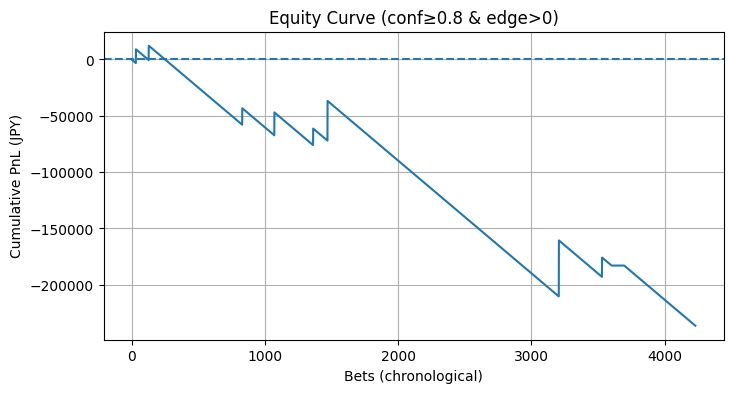

In [24]:


from roi_util import ROIAnalyzer


"""
Fetch last 90‑day races, compute edge & Kelly strategy,
and output ROI / PnL statistics + equity curve.
"""
today = dt.date.today()
start_date = today - dt.timedelta(days=20)

query = f"""
    SELECT * FROM feat.eval_features2
    WHERE race_date BETWEEN '{start_date}' AND '{today}'
"""
df_recent = pd.read_sql(query, conn)

df_recent.drop(columns=exclude, inplace=True, errors="ignore")

if df_recent.empty:
    print("[simulate] No rows fetched for last 3 months.")

print(f"[simulate] Loaded {len(df_recent)} rows ({start_date} – {today}).")
print(f"columns: {', '.join(df_recent.columns)}")

# ========== デバッグ: Dataset/Model 入力次元の一致確認 ==========
# ds_tmp = BoatRaceDataset(df_recent, mode="zscore")
# loader_tmp = DataLoader(ds_tmp, batch_size=1)
# ctx_sample, boats_sample, _, _ = next(iter(loader_tmp))
# ctx_dim = ctx_sample.shape[1]
# boat_dim = boats_sample.shape[2]
# print("✅ Dataset - ctx_dim:", ctx_dim)
# print("✅ Dataset - boat_dim:", boat_dim)

# # model_recent をデータセット次元で初期化
# model_recent = SimpleCPLNet(ctx_in=ctx_dim, boat_in=boat_dim).to(device)
# print("✅ Model - ctx_in (Linear input):", model_recent.ctx_fc.in_features)
# print("✅ Model - boat_in (Linear input):", model_recent.boat_fc.in_features)
# ============================================================

analyzer = ROIAnalyzer(model=model, scaler=scaler,
                       num_cols=NUM_COLS, device=device)

df_met = analyzer.compute_metrics_dataframe(
    df_eval=df_recent,
    calibrate="platt"        # ← Platt scaling で確率をキャリブレーション
)
df_met.to_csv("artifacts/metrics_last_3months.csv", index=False)

df_eq = ROIAnalyzer.compute_equity_curve(
    df_met,
    bet_unit=1,              # 1 unit = minimum 100 JPY wager
    bet_mode="kelly",
    min_conf=0,            # 信頼度しきい値
    min_edge=0,            # 期待値エッジの下限
    min_kelly=0.00,          # 極小ケリーはスキップ
    use_conf_factor=True     # conf に応じて賭け金をスケール
)
df_eq.to_csv("artifacts/equity_curve_last_3months.csv", index=False)

ROIAnalyzer.plot_equity_curve(df_eq,
                              title="Equity Curve (conf≥0.8 & edge>0)",
                              use_jpy=True)

# df_met.to_csv("metrics_last_3months.csv", index=False)
# df_eq.to_csv("equity_curve_last_3months.csv", index=False)
# df_eq[df_eq["bet_units"] > 0][["race_key", "first_lane", "second_lane", "third_lane", "odds", "bet_units"]].to_csv("bet_orders_last_3months.csv", index=False)
# df_eq[(df_eq["bet_units"] > 0) & (df_eq["hit"] == True)][
#     ["race_key", "first_lane", "second_lane", "third_lane", "odds", "bet_units", "pnl_jpy"]
# ].to_csv("hit_bets_last_3months.csv", index=False)
# print(f"[simulate] ROI (edge≥{tau:.2f}): {df_eq['cum_roi_jpy'].iloc[-1]:.3f} "
#       f" | Profit: {df_eq['cum_pnl_jpy'].iloc[-1]:,.0f}円 "
#       f"| Stake: {df_eq['cum_staked_jpy'].iloc[-1]:,.0f}円 "
#       f"| Bets: {len(df_eq)}")

# max_dd, _ = compute_drawdown(df_eq, use_jpy=True)
# flat_len = longest_flat_period(df_eq, use_jpy=True)
# print(f"[simulate] Max DD: {max_dd:,.0f}円 | Longest flat: {flat_len} bets")

# plot_equity_curve(df_eq,
#                   title=f'Equity (last 3M, τ={tau})',
#                   use_jpy=True,
#                   group_by="races")
# pnl_heatmap(df_met.assign(pnl_jpy=df_eq["pnl_jpy"]), value="pnl_jpy")



In [21]:


# --------------------------------------------------------------------------
#  グループ Ablation: 重要列を 5～6 個まとめてドロップして val_nll を比較
# --------------------------------------------------------------------------

# ---- Permutation Importance ----
def evaluate_model(model, dataset, device):
    model.eval()
    loader = DataLoader(dataset, batch_size=512)
    total_loss = 0
    with torch.no_grad():
        for ctx, boats, lane_ids, ranks in loader:
            ctx, boats = ctx.to(device), boats.to(device)
            lane_ids, ranks = lane_ids.to(device), ranks.to(device)
            loss = pl_nll(model(ctx, boats, lane_ids), ranks)
            total_loss += loss.item() * len(ctx)
    return total_loss / len(dataset)

def permute_importance(model, dataset, device="cpu", cols=None):
    """
    Permutation importance: 各特徴量列をランダムに permute して val_nll の悪化量を調べる
    """
    base_loss = evaluate_model(model, dataset, device)

    # ----- 列リストを決める --------------------------------------------------
    # cols=None なら「データフレームに存在する “使えそうな” 全列」を対象にする
    if cols is None:
        # 予測ターゲットやキー列は除外
        skip = {"race_key", "race_date"}
        # rank 列（教師信号）や欠損だらけの列も除外
        skip |= {c for c in dataset.f.columns if c.endswith("_rank")}
        cols = [c for c in dataset.f.columns if c not in skip]

    importances: dict[str, float] = {}
    df_full = dataset.f

    for col in cols:
        # --- その列だけランダムに permute ---
        shuffled = df_full.copy()
        shuffled[col] = np.random.permutation(shuffled[col].values)
        tmp_ds = BoatRaceDataset(shuffled, mode=dataset.mode)
        loss = evaluate_model(model, tmp_ds, device)
        importances[col] = loss - base_loss   # 悪化分 (大 → 重要)
    return importances

def run_ablation_groups(
    model_cls,
    df_full: pd.DataFrame,
    group_size: int = 6,
    epochs: int = 5,
    seed: int = 42,
    device: str = "cpu",
):
    """
    全特徴量をランダムに group_size 個ずつ束ね、
    そのグループを丸ごと削除して再学習 → val_nll を返す。

    戻り値: list[tuple[list[str], float]]
        (ドロップした列リスト, val_nll) を val_nll 昇順で並べたもの
    """
    random.seed(seed)

    essential_cols = set(NUM_COLS)          # ctx 用の連続値
    for l in range(1, 7):
        essential_cols.update({
            f"lane{l}_exh_time",
            f"lane{l}_st",
            f"lane{l}_weight",
            f"lane{l}_bf_course",
            f"lane{l}_fs_flag",
            f"lane{l}_racer_id",
            f"lane{l}_racer_name",
            f"lane{l}_racer_age",
            f"lane{l}_racer_weight",
        })
    # --- 対象列を決める（ターゲット & キー列は除外） ---
    skip = {"race_key", "race_date"}
    skip |= {c for c in df_full.columns if c.endswith("_rank")}
    skip |= essential_cols  
    skip |= {c for c in df_full.columns if c.endswith("_rank")}
    cols = [c for c in df_full.columns if c not in skip]
    random.shuffle(cols)

    groups = [cols[i : i + group_size] for i in range(0, len(cols), group_size)]
    results = []

    latest_date = pd.to_datetime(df_full["race_date"]).dt.date.max()
    cutoff = latest_date - dt.timedelta(days=90)

    for g in groups:
        df_drop = df_full.drop(columns=g)

        ds_tr = BoatRaceDataset(df_drop[df_drop["race_date"] < cutoff], mode="zscore")
        ds_va = BoatRaceDataset(df_drop[df_drop["race_date"] >= cutoff], mode="zscore")

        ld_tr = DataLoader(ds_tr, batch_size=256, shuffle=True)
        ld_va = DataLoader(ds_va, batch_size=512)

        model = model_cls().to(device)
        opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

        for _ in range(epochs):
            model.train()
            for ctx, boats, lane_ids, ranks in ld_tr:
                ctx, boats = ctx.to(device), boats.to(device)
                lane_ids, ranks = lane_ids.to(device), ranks.to(device)
                loss = pl_nll(model(ctx, boats, lane_ids), ranks)
                opt.zero_grad(); loss.backward(); opt.step()

        val_loss = evaluate_model(model, ds_va, device)
        results.append((g, val_loss))

    return sorted(results, key=lambda x: x[1])  # 小さい順に重要

print("▼ Permutation importance (ALL features)")
all_imp = permute_importance(model, ds_val, device)
imp_path = "artifacts/perm_importance_all.csv"
pd.Series(all_imp).sort_values(ascending=False).to_csv(imp_path)
print(f"[saved] {imp_path}")

# ② グループ Ablation
print("▼ Group ablation (drop 6 cols each)")
ab_results = run_ablation_groups(SimpleCPLNet, df, group_size=6,
                                    epochs=5, device=device)
abl_path = "artifacts/ablation_results.csv"
with open(abl_path, "w", newline="") as f:
    import csv
    w = csv.writer(f); w.writerow(["dropped_cols", "val_nll"])
    for cols, v in ab_results:
        w.writerow(["|".join(cols), f"{v:.6f}"])
print(f"[saved] {abl_path}")

▼ Permutation importance (ALL features)
[saved] artifacts/perm_importance_all.csv
▼ Group ablation (drop 6 cols each)


KeyError: "['lane4_bf_st_time'] not in index"

In [ ]:


# ────────────────────────────────────────────────────────────────
# ① SHAP Interaction を計算するユーティリティ
# ----------------------------------------------------------------
import shap, seaborn as sns, matplotlib.pyplot as plt
import numpy as np, torch, os

# ① 先頭付近に追加
class _ModelForShap(torch.nn.Module):
    """lane_ids を float → long に戻してから元モデルへ"""
    def __init__(self, base):
        super().__init__()
        self.base = base
    def forward(self, ctx, boats, lane_ids_f):
        return self.base(ctx, boats, lane_ids_f.long())

def shap_interaction_heatmap(model, loader_val,
                             device="cpu",
                             n_samples=128,
                             save_prefix="artifacts/shap"):
    """
    ctx(環境6変数) と boat(各艇の3変数: exh_time/st/weight) の
    相互作用を DeepExplainer で可視化する。

    例：
      - フォーム(winrate_30d_l*) × 風速(wind_speed)
      - 重量(weight)           × 追い風(wind_sin<0)
    """
    model.eval()
    os.makedirs(os.path.dirname(save_prefix), exist_ok=True)

    # ---- まずバッチを取り出して n_samples だけ切り出す ----
    ctx, boats, lane_ids, _ = next(iter(loader_val))
    ctx, boats, lane_ids = ctx[:n_samples].to(device), \
                           boats[:n_samples].to(device), \
                           lane_ids[:n_samples].to(device)

    # ---- SHAP DeepExplainer (多入力モデル) -------------------
    model_wrap = _ModelForShap(model).to(device)
    lane_ids_f = lane_ids.float()
    explainer = shap.DeepExplainer(model_wrap, [ctx, boats, lane_ids_f])
    # DeepExplainer はバージョンにより shap_interaction_values を
    # 実装していないため try / except でフォールバック
    try:
        shap_int = explainer.shap_interaction_values([ctx, boats, lane_ids_f])
        use_exact = True
    except AttributeError:
        # ---------- 近似的な Interaction 行列を自前計算 ----------
        #   |SHAP_i * SHAP_j| の平均 ≈ 交互作用の強さとみなす
        try:
            shap_vals = explainer.shap_values([ctx, boats, lane_ids_f], check_additivity=False)
        except AssertionError:
            # DeepExplainer が sum-consistency でコケたときは GradientExplainer に切替
            explainer = shap.GradientExplainer(model_wrap, [ctx, boats, lane_ids_f])
            shap_vals = explainer.shap_values([ctx, boats, lane_ids_f], check_additivity=False)
        ctx_sv   = np.asarray(shap_vals[0])        # shape (B,C)
        boat_sv  = np.asarray(shap_vals[1])        # shape (B,6,F)

        # 1) 環境 × 環境
        ctx_int_mat = np.mean(np.abs(ctx_sv[:, :, None] * ctx_sv[:, None, :]), axis=0)  # (C,C)

        # 2) Boat × Boat (lane 平均)
        #    boat_sv: (B,6,F) → (B,6,F,1) * (B,6,1,F) → (B,6,F,F)
        boat_pair = np.abs(boat_sv[:, :, :, None] * boat_sv[:, :, None, :])  # (B,6,F,F)
        boat_int_mat = boat_pair.mean((0,1))                                 # lane & batch 平均 → (F,F)

        # 3) 環境 × Boat
        cross_raw = np.abs(ctx_sv[:, :, None, None] * boat_sv[:, None, :, :])  # (B,C,6,F)
        cross_int = cross_raw.mean((0,2))                                       # (C,F)
        use_exact = False
    else:
        # ---------- 正確な Interaction (DeepExplainer 対応版) ----------
        # shap_int は list: [ctx_int, boat_int, lane_int]
        #   ctx_int  : (B, C, C)
        #   boat_int : (B, 6, F, 6, F)
        ctx_int_mat  = np.abs(shap_int[0]).mean(0)                     # (C,C)
        boat_int_raw = np.abs(shap_int[1])                             # (B,6,F,6,F)
        boat_int_mat = boat_int_raw.mean((0,1,3))                      # (F,F)

        cross_int    = boat_int_raw.mean((0,3))                        # (C,F)
    msg = "exact" if use_exact else "approx"
    print(f"[info] SHAP interaction mode: {msg}")

        # --- ensure ctx_int_mat is 2‑D (Seaborn heatmap requirement) ---
    while ctx_int_mat.ndim > 2:
        ctx_int_mat = ctx_int_mat.mean(0)

    # ---- ヒートマップ表示 ------------------------------------
    # (A) 環境どうし
    ctx_feat_names = ["air_temp","wind_speed","wave_height",
                      "water_temp","wind_sin","wind_cos"]
    plt.figure(figsize=(6,5))
    sns.heatmap(ctx_int_mat, annot=False, square=True,
                xticklabels=ctx_feat_names, yticklabels=ctx_feat_names,
                cmap="coolwarm", center=0)
    plt.title("SHAP Interaction – Environment × Environment")
    plt.tight_layout()
    plt.savefig(f"{save_prefix}_ctx_ctx.png", dpi=180)
    plt.show()

    # (B) Boat どうし
        # --- ensure boat_int_mat is 2‑D ---
    while boat_int_mat.ndim > 2:
        # 平均を最後の軸に取って次元を潰す
        boat_int_mat = boat_int_mat.mean(-1)
    # feature 数とラベル長が合わなければ自動補完
    
    boat_feat_names = ["exh_time","st","weight"]         # ← BoatRaceDataset が渡す順
    F = boat_int_mat.shape[0]
    if len(boat_feat_names) != F:
        boat_feat_names = [f"feat{i}" for i in range(F)]
    plt.figure(figsize=(4,4))
    sns.heatmap(boat_int_mat, annot=False, square=True,
                xticklabels=boat_feat_names, yticklabels=boat_feat_names,
                cmap="coolwarm", center=0)
    plt.title("SHAP Interaction – Boat × Boat (lane平均)")
    plt.tight_layout()
    plt.savefig(f"{save_prefix}_boat_boat.png", dpi=180)
    plt.show()

    # (C) 環境 × Boat
    while cross_int.ndim > 2:
        # 平均を第1軸に取りつつ次元を潰す
        cross_int = cross_int.mean(1)
    plt.figure(figsize=(5,4))
    sns.heatmap(cross_int, annot=False,
                yticklabels=ctx_feat_names,
                xticklabels=boat_feat_names,
                cmap="coolwarm", center=0)
    plt.title("SHAP Interaction – Environment × Boat")
    plt.xlabel("Boat feature"), plt.ylabel("Env feature")
    plt.tight_layout()
    plt.savefig(f"{save_prefix}_ctx_boat.png", dpi=180)
    plt.show()

    # ---- 具体的なペアの数値を抜き出す例 ----------------------
    # w_speed_idx   = ctx_feat_names.index("wind_speed")
    # headwind_idx  = ctx_feat_names.index("wind_sin")   # sin<0 が追い風
    # weight_idx    = boat_feat_names.index("weight")

    # form_idxs = [i for i,n in enumerate(boat_feat_names) if "winrate" in n]  # 例
    # form_wspeed = cross_int[w_speed_idx, weight_idx]
    # weight_head = cross_int[headwind_idx, weight_idx]
    # print(f"[form × wind_speed] interaction ≈ {form_wspeed:.4f}")
    # print(f"[weight × headwind] interaction ≈ {weight_head:.4f}")

# ─── 呼び出し ───
shap_interaction_heatmap(model, loader_val, device=device, n_samples=128)

In [ ]:


# ============================================================
# ④ ── 「勾配が流れているか」を瞬時に確認する Snippet
#       （エポック終了後 1 回だけ走らせれば十分）
# ------------------------------------------------------------

# ============================================================
 
 # ============================================================
 # ⑤ ── 超小規模データで「過学習できるか」テスト関数
 #       必要時に呼び出して 0.1 以下まで loss が落ちるか確認
 # ------------------------------------------------------------
def overfit_tiny(df: pd.DataFrame, device: str = "cpu"):
    """
    データセットを 10 行だけに縮小し、500 step で過学習できるか検証
    """
    tiny_df = df.sample(10, random_state=1).reset_index(drop=True)
    tiny_ds = BoatRaceDataset(tiny_df, mode=mode)
    tiny_loader = DataLoader(tiny_ds, batch_size=10, shuffle=True)

    net = SimpleCPLNet().to(device)
    opt = torch.optim.AdamW(net.parameters(), lr=3e-3)

    for _ in range(500):
        ctx, boats, lane_ids, ranks = next(iter(tiny_loader))
        ctx, boats = ctx.to(device), boats.to(device)
        lane_ids, ranks = lane_ids.to(device), ranks.to(device)

        loss = pl_nll(net(ctx, boats, lane_ids), ranks)
        opt.zero_grad(); loss.backward(); opt.step()

    print("[tiny] final loss:", loss.item())


# ---- tiny データで特徴量の分散を確認 -----------------------
tiny_df = df.sample(10, random_state=1).reset_index(drop=True)
num_cols = tiny_df.select_dtypes(include="number").columns

# (1) 行間（=レース間）での分散
print("► 行間 variance (should be >0):")
print(tiny_df[num_cols].var().nsmallest(10))

# (2) 同一レース内（= 6 艇間）での分散
def per_race_var(col):
    return tiny_df.groupby("race_key")[col].var().mean()

per_race = {c: per_race_var(c) for c in num_cols}
print("\n► 6 艇間 variance:")
print(sorted(per_race.items(), key=lambda x: x[1])[:10])

# ---- 呼び方例 ----
overfit_tiny(df, device)
# ============================================================

In [ ]:


torch.save({
    "state_dict": model.state_dict(),
    "scaler": scaler_filename,
    "venue2id": venue2id,
    # "race_type2id": race_type2id
}, "cplnet_checkpoint.pt")

In [ ]:


# ============================================================
# ★ 予測用スクリプト（直近3ヶ月データを使って予測） ★
# ============================================================

def run_experiment(data_frac, df_full, mode="zscore", epochs=5, device="cpu"):
    df_frac = df_full.sample(frac=data_frac, random_state=42)
    df_frac["race_date"] = pd.to_datetime(df_frac["race_date"]).dt.date
    latest_date = df_frac["race_date"].max()
    cutoff = latest_date - dt.timedelta(days=90)  # last 3 months used as validation set
    ds_train = BoatRaceDataset(df_frac[df_frac["race_date"] < cutoff], mode=mode)
    ds_val = BoatRaceDataset(df_frac[df_frac["race_date"] >= cutoff], mode=mode)

    loader_train = DataLoader(ds_train, batch_size=256, shuffle=True)
    loader_val = DataLoader(ds_val, batch_size=512)

    boat_dim = ds_train.boat_dim
    model = SimpleCPLNet(boat_in=boat_dim).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

    for epoch in range(epochs):
        model.train()
        for ctx, boats, lane_ids, ranks in loader_train:
            ctx, boats = ctx.to(device), boats.to(device)
            lane_ids, ranks = lane_ids.to(device), ranks.to(device)
            loss = pl_nll(model(ctx, boats, lane_ids), ranks)
            opt.zero_grad(); loss.backward(); opt.step()

    train_loss = evaluate_model(model, ds_train, device)
    val_loss = evaluate_model(model, ds_val, device)
    return train_loss, val_loss

# 学習曲線の描画
def plot_learning_curve(df, device):
    data_fracs = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
    results = []

    for frac in data_fracs:
        tr_loss, val_loss = run_experiment(frac, df, device=device)
        print(f"Data frac {frac:.2f} → Train: {tr_loss:.4f} / Val: {val_loss:.4f}")
        results.append((frac, tr_loss, val_loss))

    fracs, tr_losses, val_losses = zip(*results)
    plt.plot(fracs, tr_losses, label="Train Loss")
    plt.plot(fracs, val_losses, label="Val Loss")
    plt.xlabel("Training Data Fraction")
    plt.ylabel("Loss")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

def predict_latest_3months():
    import datetime as dt
    today = dt.date.today()
    three_months_ago = today - dt.timedelta(days=90)

    query = f"""
        SELECT * FROM feat.train_features
        WHERE race_date BETWEEN '{three_months_ago}' AND '{today}'
    """
    df_pred = pd.read_sql(query, conn)
    print(f"[predict] Loaded {len(df_pred)} rows for prediction")

    # --- 前処理 ---
    df_pred["wind_dir_rad"] = np.deg2rad(df_pred["wind_dir_deg"])
    df_pred["wind_sin"] = np.sin(df_pred["wind_dir_rad"])
    df_pred["wind_cos"] = np.cos(df_pred["wind_dir_rad"])
    df_pred[NUM_COLS] = scaler.transform(df_pred[NUM_COLS])

    bool_cols = [c for c in df_pred.columns if c.endswith("_fs_flag")]
    df_pred[bool_cols] = df_pred[bool_cols].fillna(False)
    rank_cols = [f"lane{l}_rank" for l in range(1, 7)]
    df_pred[rank_cols] = df_pred[rank_cols].fillna(7).astype("int32")

    pred_ds = BoatRaceDataset(df_pred, mode="zscore")
    pred_loader = DataLoader(pred_ds, batch_size=1)

    model.eval()
    for i, (ctx, boats, lane_ids, _) in enumerate(pred_loader):
        ctx, boats, lane_ids = ctx.to(device), boats.to(device), lane_ids.to(device)
        with torch.no_grad():
            scores = model(ctx, boats, lane_ids)  # (1,6)
            pred_rank = scores.squeeze().argsort(descending=True).argsort() + 1
            # print(f"[{i:03d}] 予測順位:", pred_rank.cpu().numpy())

    # --- 追加: 固定着順との比較評価 ---
    def evaluate_against_fixed_ranks(pred_loader):
        """
        着順 [1,2,3,4,5,6] を常に予測したと仮定した場合と、モデルの予測を比較する
        """
        model_correct = [0] * 6
        fixed_correct = [0] * 6
        total = 0

        model.eval()
        for _, (ctx, boats, lane_ids, true_ranks) in enumerate(pred_loader):
            ctx, boats, lane_ids = ctx.to(device), boats.to(device), lane_ids.to(device)
            true_ranks = true_ranks.to(device)

            with torch.no_grad():
                scores = model(ctx, boats, lane_ids)
                pred_rank = scores.squeeze().argsort(descending=True).argsort() + 1  # (6,)

            total += 1
            for i in range(6):
                # モデルがその艇の着順を当てたか
                if pred_rank[i].item() == true_ranks[0][i].item():
                    model_correct[i] += 1
                # 固定予測 [1,2,3,4,5,6] を使った場合
                if (i + 1) == true_ranks[0][i].item():
                    fixed_correct[i] += 1

        print("\n--- モデル vs 固定着順 予測精度 ---")
        for i in range(6):
            print(f"{i+1}着: モデル={model_correct[i]/total:.3f}  固定={fixed_correct[i]/total:.3f}  (正解数: モデル={model_correct[i]} 固定={fixed_correct[i]})")

    evaluate_against_fixed_ranks(pred_loader)

# 呼び出し例

plot_learning_curve(df, device)
predict_latest_3months()

# ======================================================================